In [93]:
from __future__ import division

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
from utils import get_data
version = '1.0'
data = get_data(version, '../data')
df = data['blockworld']

In [121]:
def parse_state(state):
    return tuple((tuple(filter(None, col.split(','))) 
                  for col in state.split(':')))

df.states = df.states.apply(lambda states: list(map(parse_state, states)))

In [122]:
# Cleaning erroneous data where some states are repeated.
# Totally strange, as we don't permit this in the UI... So we should also prohibit this in logic I think...
# TODO

for row_idx, row in df.iterrows():
    states = row.states

    result = []
    for idx, state in enumerate(states):
        if idx == 0 or state != states[idx-1]:
            result.append(state)
        else:
            print(f'Warning: For row {row_idx} pid {row.pid}, had to exclude repeated state at index {idx}.')

    if len(result) != len(row.states):
        df.at[row_idx, 'states'] = result

In [4]:
df.head()

,states,time_elapsed,times,trial_type,pid
0,"[((), (C, B), (A,)), ((), (C, B, A), ())]",42447,[2641],blockworld,1
1,"[((), (B, D, A), (C,)), ((), (B, D, A, C), ())...",110394,"[8282, 21972, 23209, 24745, 28025, 30305, 3158...",blockworld,1
2,"[((C,), (A, E, B, D), ()), ((C,), (A, E, B), (...",142769,"[7094, 9246, 12341, 16638, 17918, 19870, 21902...",blockworld,1
3,"[((E,), (C, B, A), (D,)), ((E,), (C, B), (D, A...",170177,"[7788, 8967, 9646, 11694, 13893, 14972, 16524,...",blockworld,1
4,"[((E, B), (C, A, D), ()), ((E,), (C, A, D), (B...",215471,"[8210, 9302, 11774, 13726, 17814, 22374, 24937...",blockworld,1


In [5]:
unique_problems = set([s[0] for s in df.states])
unique_problems_5block = [
    p for p in unique_problems
    if sum(len(col) for col in p) == 5
]
# We have 15 problems across all people
len(unique_problems_5block)

15

In [6]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import agent
import blockworld

XXX show acting optimally?? so # of moves relative to optimal on a plot

compute # of reversals -> defined by removing/detecting cycles

% of moves that are optimal -> simpler version of xxxxx

- xXX need all optimal moves xxx
- data sructure of actions X agents
- get_actions(state) -> list of actions agent would take
- think about probabs of each action
    - should be weighted by # of other actions that share the same first sequences?
      so 
    - uniform over action paths migth be close but probably isn't enough
    
quantify learning effects with % optimal ~ trial #

XXX so do mixture model where each has a value of K. so one model for each k

!! big goal is to show whether or not k explains more than depth limited

add lru cache

think about getting distinct action sequence setssss

counterbalancing: for each sequence, do we reverse it??

second don norman paper xxx

reactions:
- later moves are often optimal. but mixed model will just show that it's harder to say which agent would have made move since most would... Can we make plot to show later moves are more often optimal?
- need to plot out learning effects. % optimal over trials. or likely agent over trials.

old

- latency variables???
- correlate prediction of k based on either # moves or latency time
    - only expect latency effect with k if they're replanning every k so maybe not useful...
- so maybe look at latency in relation to goal completion ; something as simple as t test?

In [7]:
def _generate_standard_goals_for_tol(initial, column_index=0, debug=True):
    letters = sorted([l for ls in initial for l in ls])
    goals = []
    for top, bottom in reversed(list(zip(letters[:-1], letters[1:]))):
        goals.append(blockworld.Blockworld.make_above_predicate(top, bottom))
    goals_with_clearing = [blockworld.Blockworld.make_is_bottom_of_column_predicate(letters[-1], column_index=column_index)]+goals
    if debug:
        for idx, g in enumerate(goals_with_clearing):
            print('Goal {}: {}'.format(idx, g.__name__))
    return goals_with_clearing

goals_with_clearing = _generate_standard_goals_for_tol(unique_problems_5block[0], column_index=1)
kvals = range(1, len(goals_with_clearing)+1)

lengths = []
for initial in unique_problems_5block:
    problem = blockworld.Blockworld(initial, goals_with_clearing, height_limits=(5, 5, 5))
    len_optimal = len(agent.bfs_search(problem))
    kres = []
    for k in kvals:
        results = [
            # returns history, solved
            agent.solve_using_ordered_goal_subset_astar(problem, k=k)
            for _ in range(10)
        ]
        assert all(solved for history, solved in results), f'Did not solve for problem={initial} k={k}'
        scores = [len(h) - 1 for h, _ in results]
        kres.append(scores)
    lengths.append((initial, len_optimal, kvals, kres))


Goal 0: E is at the bottom of column 1
Goal 1: D is on top of E
Goal 2: C is on top of D
Goal 3: B is on top of C
Goal 4: A is on top of B


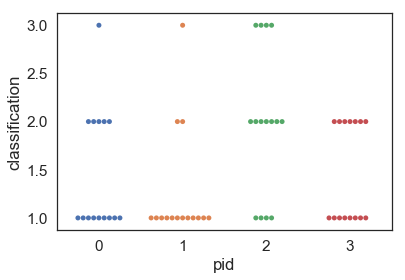

In [8]:
subject_k = [[] for _ in df.pid.unique()]

for initial, len_optimal, kvals, kres in lengths:
    minkr = np.min(kres, axis=1)
    maxkr = np.max(kres, axis=1)
    meankr = np.mean(kres, axis=1)
    filt = df[df.states.apply(lambda s: s[0] == initial)]

    for _, row in filt.iterrows():
        num_moves = len(row.states)-1 # subtract 1 for initial
        classified = next((
            kvals[idx]
            for idx, (kmin, kmax, kmean) in enumerate(zip(minkr, maxkr, meankr))
            #if kmin <= num_moves and num_moves <= kmax
            if kmean <= num_moves
        ), None)
        subject_k[row.pid].append(classified)

subject_df = pd.DataFrame([
    dict(pid=pid, classification=k)
    for pid, classifications in enumerate(subject_k)
    for k in classifications
])
sns.swarmplot(x='pid', y='classification', data=subject_df)


In [96]:
def _compute_action(state, next_state):
    '''
    Determines action taken to go from blockworld state to next_state.
    '''
    greater = [
        idx for idx, (col, next_col) in enumerate(zip(state, next_state))
        if len(next_col) > len(col)
    ]
    smaller = [
        idx for idx, (col, next_col) in enumerate(zip(state, next_state))
        if len(next_col) < len(col)
    ]
    msg = f'_compute_action {state} {next_state}'
    assert len(greater) == 1, msg
    assert len(smaller) == 1, msg

    source_idx = smaller[0]
    destination_idx = greater[0]
    moved_letter = next_state[destination_idx][-1]

    assert state[source_idx][-1] == moved_letter, msg

    return (moved_letter, destination_idx)

assert _compute_action(((), ('A')), (('A'), ())) == ('A', 0)
assert _compute_action(((), ('B', 'A')), (('A'), ('B'))) == ('A', 0)

In [138]:
from functools import lru_cache

# We want to see what the optimal agent would do in each circumstance.

@lru_cache(maxsize=512)
def get_actions(state, k=None):
    '''problem = Blockworld(
        (('D', 'A'), ('C', 'B'), ()),
        [
            Blockworld.make_above_predicate(top, bottom)
            for (top, bottom) in [('C', 'D'), ('B', 'C'), ('A', 'B')]
        ],
    )'''
    if k is None:
        k = len(goals_with_clearing)
    problem = blockworld.Blockworld(initial, goals_with_clearing)
    # HACK could use next_goal to find out how far into states to go
    next_goal, goal_test, h = agent.make_ordered_k_goal_cost_heuristic(
        problem, state, k=k, debug=False)
    solutions = agent.A_Star(
        problem,
        h,
        start=state,
        goal_test=goal_test,
        return_all_equal_cost_paths=True,
        shuffle=False)
    # HACK do we just get next actions or all actions xxxxxx
    next_actions = [
        actions[0]
        for actions, states in solutions
    ]
    # HACK should they be unique?
    # HACK probably not, so we can do some weighting on the other end ??
    return next_actions

# We compute the probability that each agent would take the action the participant took.

def probability_of_actions(row, agents):
    participant_actions = [
        _compute_action(s, s_next)
        for s, s_next in zip(row.states[:-1], row.states[1:])
    ]
    assert len(participant_actions) == len(row.states) - 1

    p_action = np.zeros((len(participant_actions), len(agents)))

    for agent_idx, (agent_name, get_act) in enumerate(agents):
        for action_idx, (state, participant_action) in enumerate(zip(row.states[:-1], participant_actions)):
            agent_actions = get_act(state)
            # HACK for now we assume each action from agent is of equal likelihood. In future, we might prefer compute_action_path_probabilities
            same_action = sum(1 if a == participant_action else 0 for a in agent_actions)
            p_action[action_idx, agent_idx] = same_action / len(agent_actions)

    return p_action

# 

# So we want something like:
# make array of agents X states/actions
# what are the odds the agent would make that move from that state?
# for now do uniform odds
# for our simplifying case we'll have one agent
# and we'll simply look for non-zero prob that agent would make that move
# so we count non-zero prob for agent to make that move

agents = [
    ('optimal', lambda s: get_actions(s)),
    #('k=1', lambda s: get_actions(s, k=1)),
]

percent_optimal_moves = np.zeros((len(unique_problems_5block), len(df.pid.unique())))

for problem_idx, initial in enumerate(tqdm(unique_problems_5block)):
    filt = df[df.states.apply(lambda s: s[0] == initial)]
    for _, row in filt.iterrows():
        p_actions = probability_of_actions(row, agents)
        percent_optimal_moves[problem_idx, row.pid] = np.sum(p_actions > 0, axis=0) / p_actions.shape[0]

percent_optimal_moves

array([[0.76923077, 0.84615385, 0.76923077, 0.90909091],
       [1.        , 0.76923077, 0.90909091, 0.81818182],
       [0.9       , 0.9       , 1.        , 0.75      ],
       [0.81818182, 0.83333333, 0.76923077, 0.90909091],
       [0.73333333, 0.84615385, 1.        , 0.63157895],
       [0.58823529, 0.76923077, 1.        , 0.78571429],
       [0.625     , 1.        , 1.        , 0.71428571],
       [0.81818182, 0.64705882, 0.75      , 0.81818182],
       [0.64705882, 0.58823529, 0.90909091, 0.625     ],
       [0.9       , 0.75      , 0.81818182, 0.71428571],
       [0.6       , 0.71428571, 1.        , 0.625     ],
       [0.66666667, 0.63157895, 0.71428571, 0.75      ],
       [0.75      , 0.81818182, 0.9       , 0.90909091],
       [0.70588235, 0.78571429, 0.83333333, 0.71428571],
       [0.90909091, 0.69230769, 1.        , 0.75      ]])

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


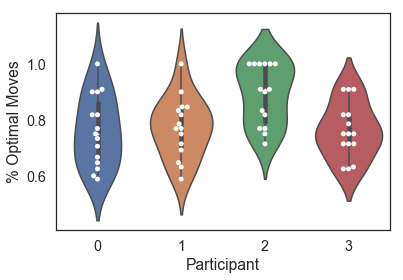

In [139]:
subject_df = pd.DataFrame([
    dict(problem=problem, pid=pid, percent=percent_optimal_moves[problem, pid])
    for problem, pid in np.ndindex(*percent_optimal_moves.shape)
])

f, ax = plt.subplots()
sns.violinplot(x='pid', y='percent', data=subject_df, ax=ax)
sns.swarmplot(x='pid', y='percent', data=subject_df, color='white', ax=ax)

ax.set_ylabel('% Optimal Moves')
ax.set_xlabel('Participant')

None

(11,) (11,)
p_err.shape (50, 1) logp.shape (50, 11)
MLE error prob: 0.12244897959183673


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


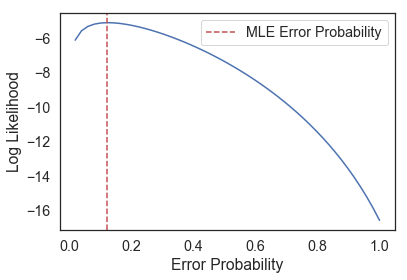

In [227]:
def fit_p_err(model_p, rand_p, debug=False):
    def noisy_model_p(p_err):
        return (1 - p_err) * model_p + p_err * rand_p

    # indexing trick [:, None] adds new dim to use vectorized ops via broadcasting
    p_err = np.linspace(0,1)[:, None]
    logp = np.log(noisy_model_p(p_err))
    if debug:
        print('p_err.shape', p_err.shape, 'logp.shape', logp.shape)
    total_logp = logp.sum(-1)  # sum logp across trials
    i = np.argmax(total_logp)
    best_p_err = p_err[i]

    if debug:
        plt.plot(p_err, total_logp)
        plt.xlabel('Error Probability')
        plt.ylabel('Log Likelihood')
        plt.axvline(best_p_err, c='r', ls='--', label='MLE Error Probability')
        plt.legend()

    return best_p_err[0]

agent_idx = 3
model_p = p_actions[:, agent_idx]
rand_p = np.array([1/len(problem.actions(s)) for s in row.states[:-1]])
print(model_p.shape, rand_p.shape)
print('MLE error prob:', fit_p_err(model_p, rand_p, debug=True))

In [228]:
# HACK verify that there's more than one action in some cases... !!!!
# HACK verify that there's more than one action in some cases... !!!!
# HACK verify that there's more than one action in some cases... !!!!
# HACK verify that there's more than one action in some cases... !!!!

agents = [
    ('optimal', lambda s: get_actions(s)),
    ('k=1', lambda s: get_actions(s, k=1)),
    ('k=2', lambda s: get_actions(s, k=2)),
    ('k=3', lambda s: get_actions(s, k=3)),
    ('k=4', lambda s: get_actions(s, k=4)),
]

p_err = np.zeros((len(unique_problems_5block), len(df.pid.unique()), len(agents)))

for problem_idx, initial in enumerate(tqdm(unique_problems_5block)):
    filt = df[df.states.apply(lambda s: s[0] == initial)]
    for _, row in tqdm(list(filt.iterrows()), leave=False):
        p_actions = probability_of_actions(row, agents)
        rand_p = np.array([1/len(problem.actions(s)) for s in row.states[:-1]])
        for agent_idx in range(len(agents)):
            model_p = p_actions[:, agent_idx]
            p_err[problem_idx, row.pid, agent_idx] = fit_p_err(model_p, rand_p, debug=False)


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


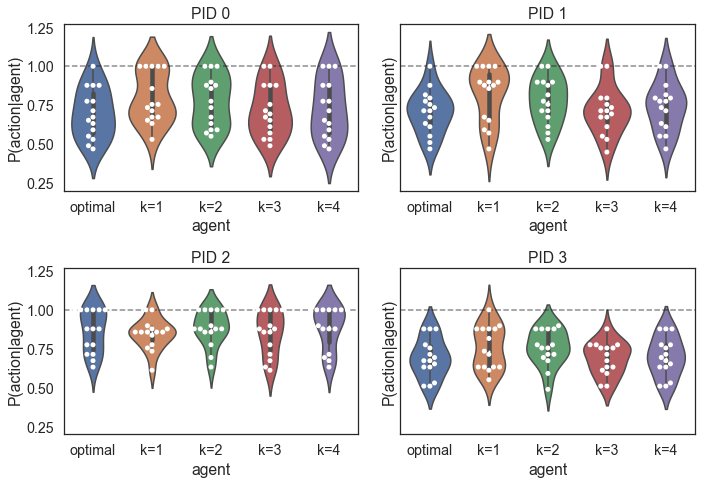

In [235]:
f, axes = plt.subplots(2, 2, figsize=(10, 7), sharey=True)

for ax, pid in zip(axes.flat, range(df.pid.max()+1)):
    p_err_df = pd.DataFrame([
        dict(pid=pid, agent=agents[agent_idx][0], p_err=1-p_err[problem_idx, pid, agent_idx])
        for problem_idx, agent_idx in np.ndindex(*p_err[:, pid, :].shape)
    ])

    sns.violinplot(x='agent', y='p_err', data=p_err_df, ax=ax)
    sns.swarmplot(x='agent', y='p_err', data=p_err_df, color='white', ax=ax)
    ax.axhline(1, ls='--', color='k', alpha=0.5)

    ax.set_ylabel('P(action|agent)')
    #ax.set_xlabel('Agent')
    ax.set_title(f'PID {pid}')
plt.tight_layout()

Text(0, 0.5, 'Log likelihood')

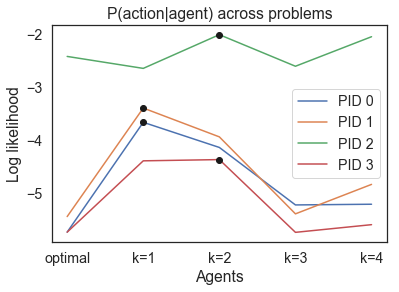

In [233]:
ll = np.sum(np.log(1-p_err), axis=0)

f, ax = plt.subplots()
names = [name for name, _ in agents]
for pid in range(df.pid.max()+1):
    ax.plot(names, ll[pid, :], label=f'PID {pid}')
    max_agent = np.argmax(ll[pid, :])
    max_dot = ax.plot(names[max_agent], ll[pid, max_agent], 'o', c='k')

ax.legend()
ax.set_title('P(action|agent) across problems')
ax.set_xlabel('Agents')
ax.set_ylabel('Log likelihood')

(15, 4)
Counter({1: 9, 2: 3, 0: 2, 3: 1})
Counter({1: 10, 2: 3, 0: 2})
Counter({0: 9, 1: 3, 2: 1, 4: 1, 3: 1})
Counter({1: 7, 0: 4, 2: 4})


Text(0, 0.5, 'Count where max LL')

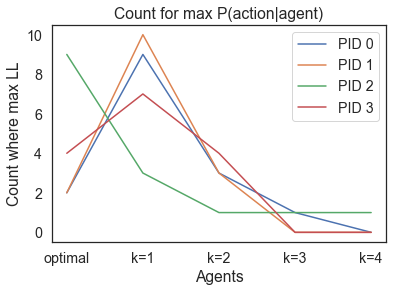

In [234]:
# HACK does this not work because some people have same value for max ????
best_agent = np.argmax(1-p_err, axis=2)
print(best_agent.shape)

from collections import Counter

f, ax = plt.subplots()
names = [name for name, _ in agents]
for pid in range(df.pid.max()+1):
    ct = Counter(best_agent[:, pid])
    print(ct)
    ax.plot(names, [ct[agent_idx] for agent_idx in range(len(agents))], label=f'PID {pid}')

ax.legend()
ax.set_title('Count for max P(action|agent)')
ax.set_xlabel('Agents')
ax.set_ylabel('Count where max LL')